In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)
matplotlib 3.6.3
numpy 1.22.3
pandas 1.5.2
sklearn 1.2.0
torch 1.13.1+cu117
cuda:0


## 数据准备

In [2]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

/bin/zsh: /home/ouyanghongyu/anaconda3/envs/pytorch/lib/libtinfo.so.6: no version information available (required by /bin/zsh)
--2023-04-24 22:25:16--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
正在解析主机 storage.googleapis.com (storage.googleapis.com)... 142.251.43.16, 172.217.160.80, 142.251.42.240, ...
正在连接 storage.googleapis.com (storage.googleapis.com)|142.251.43.16|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 1115394 (1.1M) [text/plain]
正在保存至: ‘shakespeare.txt.1’

shakespeare.txt.1   100%[===================>]   1.06M  3.15MB/s    用时 0.3s    

2023-04-24 22:25:17 (3.15 MB/s) - 已保存 ‘shakespeare.txt.1’ [1115394/1115394])



In [3]:
# https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
#文件已经下载好了
with open("./shakespeare.txt", "r", encoding="utf8") as file:
    text = file.read()

print("length", len(text))
print(text[0:100])

length 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### 构造字典

In [4]:
# 1. generate vocab
# 2. build mapping char->id
# 3. data -> id_data  把数据都转为id
# 4. a b c d [EOS] -> [BOS] b c d  预测下一个字符生成的模型，也就是输入是a，输出就是b

#去重，留下独立字符，并排序
vocab = sorted(set(text))
print(len(vocab))
print(vocab)

65
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
for idx,char in enumerate(['how','are','you']):
    print(idx,char)

0 how
1 are
2 you


In [6]:
#每个字符都编好号，enumerate对每一个位置编号，生成的是列表中是元组，下面字典生成式
char2idx = {char:idx for idx, char in enumerate(vocab)}
print(char2idx)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


In [7]:
# 把vocab从列表变为ndarray
idx2char = np.array(vocab)
print(idx2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [8]:
#把字符都转换为id
text_as_int = np.array([char2idx[c] for c in text])
print(text_as_int.shape)
print(len(text_as_int))
print(text_as_int[0:10])
print(text[0:10])

(1115394,)
1115394
[18 47 56 57 58  1 15 47 58 47]
First Citi


### 把莎士比亚文集分成一个一个的样本

In [9]:
from torch.utils.data import Dataset, DataLoader

class CharDataset(Dataset):
    def __init__(self, text_as_int, seq_length):
        self.sub_len = seq_length + 1
        self.text_as_int = text_as_int
        self.num_seq = len(text_as_int) // self.sub_len
        
    def __getitem__(self, index):
        return self.text_as_int[index * self.sub_len: (index + 1) * self.sub_len]
    
    def __len__(self):
        return self.num_seq
    
def collat_fct(batch):
    src_list = []
    trg_list = []
    for part in batch:
        src_list.append(part[:-1])
        trg_list.append(part[1:])
        
    src_list = np.array(src_list)
    trg_list = np.array(trg_list)
    return torch.Tensor(src_list).to(dtype=torch.int64), torch.Tensor(trg_list).to(dtype=torch.int64)
        

train_ds = CharDataset(text_as_int, 100)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collat_fct)

## 定义模型

In [10]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=1024):
        super(CharLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        x = self.fc(output)
        return x, hidden
    
    
vocab_size = len(vocab)
sample_inputs = torch.randint(0, vocab_size, (2, 100))
    
print("{:=^80}".format(" 一层单向 LSTM "))       
for key, value in CharLSTM(vocab_size).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")
    
CharLSTM(vocab_size)(sample_inputs)[0].shape

================================== 一层单向 LSTM ===================================
            embedding.weight            paramerters num: 16640
           lstm.weight_ih_l0            paramerters num: 1048576
           lstm.weight_hh_l0            paramerters num: 4194304
            lstm.bias_ih_l0             paramerters num: 4096
            lstm.bias_hh_l0             paramerters num: 4096
               fc.weight                paramerters num: 66560
                fc.bias                 paramerters num: 65


torch.Size([2, 128, 65])

In [1]:
4 * 1024*256

1048576

In [2]:
4 * 1024*1024

4194304

## 训练

In [11]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [12]:
# 训练
def training(
    model, 
    train_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    save_ckpt_callback=None,
    stateful=False      # 想用stateful，batch里的数据就必须连续，不能打乱
    ):
    record_dict = {
        "train": [],
    }
    
    global_step = 0
    model.train()
    hidden = None
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits, hidden = model(datas, hidden=hidden if stateful else None)
                # 计算损失
                loss = loss_fct(logits.reshape(-1, vocab_size), labels.reshape(-1))
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
 
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })
   
                # 保存模型权重 save model checkpoint
                if save_ckpt_callback is not None:
                    save_ckpt_callback(global_step, model.state_dict(), metric=-loss)
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 100

model = CharLSTM(vocab_size=vocab_size)

# 1. 定义损失函数 采用交叉熵损失 
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/text_generation_lstm", save_step=1000, save_best_only=True)


model = model.to(device)
record = training(
    model, 
    train_dl, 
    epoch, 
    loss_fct, 
    optimizer, 
    save_ckpt_callback=save_ckpt_callback,
    )

  0%|          | 0/17300 [00:00<?, ?it/s]

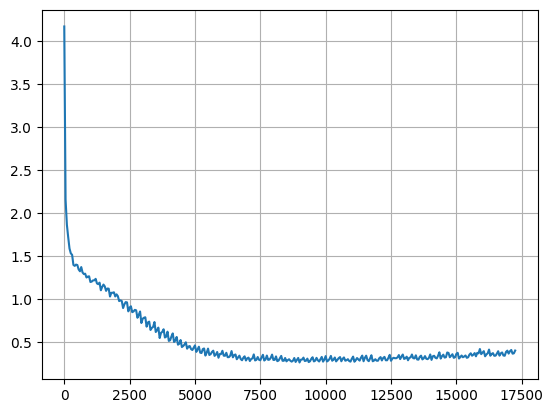

In [13]:
plt.plot([i["step"] for i in record["train"][::50]], [i["loss"] for i in record["train"][::50]], label="train")
plt.grid()
plt.show()

## 推理

In [18]:
def generate_text(model, start_string, max_len=1000, temperature=1.0, stream=True):
    input_eval = torch.Tensor([char2idx[char] for char in start_string]).to(dtype=torch.int64, device=device).reshape(1, -1)
    hidden = None
    text_generated = []
    model.eval()
    pbar = tqdm(range(max_len))
    print(start_string, end="")
    with torch.no_grad():
        for i in pbar:
            logits, hidden = model(input_eval, hidden=hidden)
            # 温度采样
            logits = logits[0, -1, :] / temperature
            # using multinomial to sampling
            probs = F.softmax(logits, dim=-1)
            idx = torch.multinomial(probs, 1).item()
            input_eval = torch.Tensor([idx]).to(dtype=torch.int64, device=device).reshape(1, -1)
            text_generated.append(idx)
            if stream:
                print(idx2char[idx], end="", flush=True)
    return "".join([idx2char[i] for i in text_generated])


torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# load checkpoints
model.load_state_dict(torch.load("checkpoints/text_generation_lstm/best.ckpt", map_location="cpu"))
start_string = "All: "
res = generate_text(model, start_string, max_len=1000, temperature=0.5, stream=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

All: what's the news?

Second Messenger:
Sir, you shall never go to-day?

PETRUCHIO:
Petruchio is chief to protector?

ELBOW:
I pray you hear it, and will say it is too much.

ANGELO:
No marry with a valour with a gentlern blisters
Of mortals than a party to the good,
And not be too sure nor privileges;
Or, if not, unless you were so contented
That he is based, in quiet. Nie, charge thee, fellow,
He caper in blood, and blows the world be full.

GONZALO:
Not a word, a word.

MENENIUS:
Why, then I'll try what I am, and there an end.

BAPTISTA:
Why, tell me, is nothing finding to you.

PETRUCHIO:
To her, farewell.

GREMIO:
And so in what?

HERMIONE:
Nay, come again.

DUKE VINCENTIO:
And you, good lord; a man't must die.

ISABELLA:
What is your will?

DUKE VINCENTIO:
Bold power that I may say indeed
Than in the fore-appreasers.

CORIOLANUS:
Wiffer much, being madam, and you must say.

LORD BERKELEY:
Mistake me not; I speak with him to-day.

BENVOLIO:
Would they have made with you so soft t